In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

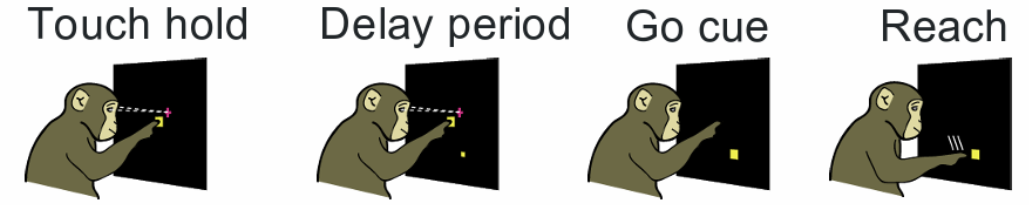

In [2]:
with open('datos_disparos_mono_tp2.npz', 'rb') as loadfile:
    spike_times = np.load(loadfile, allow_pickle=True)['spike_times'] #shape = 1127 episodios, 190 neuronas, nro de disparos (variable).
                                                                      #Recomendamos mirar len(spike_times), len(spike_times[n]), etc. para entender bien los datos

with open('metadata_mono_tp2.npy', 'rb') as loadfile:
    metadata = np.load(loadfile)
    time_touch_held = metadata['time_touch_held'] # tiempos de aparición del target para cada episodio
    time_go_cue = metadata['time_go_cue'] # tiempo de señal de GO (comienzo del movimiento) para cada episodio
    time_target_acquired = metadata['time_target_acquired'] # tiempo en que el objetivo fue tocado para cada episodio
    trial_reach_target = metadata['trial_reach_target'] # índice de a que target tenía que ir para cada episodio (0 a 7)
    target_locations = metadata['target_locations'] #  posición x,y de cada target
    target_angles = metadata['target_angles'] # ángulo de cada target


In [3]:
# Notar que hay dos duraciones de periodo de planificación
np.unique(time_go_cue - time_touch_held)

array([ 755, 1005], dtype=int64)

In [3]:
def extract_plan_spikes(window_length=None,
                        start_offset=None):
    # Devuelve una matriz de conteos de disparos en la ventana de planificación
    # - La ventana de planificación default está definida como el tiempo
    #   entre time_touch_held y time_go_cue para cada episodio.
    #   NOTA: no todos los episodios tienen la misma duración!
    # - Si se especifica una "window_length" (longitud de ventana), devuelve el número
    #   de disparos en la ventana para esa duración. Retorna -1 si el periodo de planificación
    #   es demasiado corto para la ventana (ej. si window_length=1000 pero el periodo de
    #   planificación era 755ms)
    # - Si se especifica un "start_offset", retorna el número de disparos en la ventana
    #   que empieza "start_offset" ms después de time_touch_held (y usa time_go_cue o la
    #   window_length opcional para determinar el final de la ventana). Si start_offset
    #   es tan grande que se extiende más que time_go_cue, retorna -1

    if start_offset:
        trial_starts = time_touch_held + start_offset
    else:
        trial_starts = time_touch_held

    plan_spikes = []
    for tx, trialSpikes in enumerate(spike_times):#Para cada una de las neuronas (o más bien, para cada tren de disparo, que c/u pertenece a una neurona)
        if window_length:
            trial_end = trial_starts[tx] + window_length
        else:
            trial_end = time_go_cue[tx]

        if (trial_end < trial_starts[tx]):
            raise ValueError("El final del episodio (trial_end) es menor que el comienzo (trial_starts)")
                # plan_spikes.append(-np.ones(len(trialSpikes)))
        elif (trial_end > time_go_cue[tx]):
            raise ValueError("El final del episodio (trial_end) es menor que el final del periodo de planificación (time_go_cue)")
        else:
            plan_spikes.append(#Sim
                np.array([np.sum((st > trial_starts[tx]) &
                        (st < trial_end)) for st in trialSpikes]))#Contamos cuantos disparos hubo en esa ventana!
    return np.array(plan_spikes) # debería ser de 1127 x 190 (nro de episodios x nro de neuronas)

In [6]:
def multivariate_poisson_logpdf(mu, x, mean_eps=0.01):
    # asume mu es dimensión (N,) y x es (d,N)
    mu2 = mu
    mu2[np.argwhere(mu < mean_eps)] = mean_eps # setea un promedio de disparos muy bajitos para los que daban 0 para evitar que tenga probabilidad 0
    return np.sum(x * np.log(mu2) - mu2, axis=1)

### Ejercicio 1.a

In [11]:
# plan_spikes = extract_plan_spikes()
plan_spikes = extract_plan_spikes(window_length=750) # Ej 1.a


Separemos los episodios en set de entrenamiento y testeo

In [12]:
# selecciona los episodios con duración de periodo de planificación de 755 ms
short_trials = (time_go_cue - time_touch_held) == 755 # array booleano de longitud 1127 con todos los episodios de duración 755ms en 1 y el resto en 0

training_trials = [] # van a ser 8 listas de episodios (una para cada clase)
test_trials = [] # todos los que sobran
for c in range(8): # targets del 0 al 7

    # target_trials = np.argwhere(short_trials & (trial_reach_target==c)).squeeze() # Original
    target_trials = np.argwhere(trial_reach_target==c).squeeze()

    # seleccionar 25 episodios al azar (por cada dirección)
    random_training_trials = np.random.choice(target_trials, 25, replace=False)
    training_trials.append(random_training_trials)
    remaining_test_trials = np.setdiff1d(target_trials, random_training_trials)

    test_trials.extend(remaining_test_trials)


In [13]:
# Calcular el nro promedio de disparos por neurona y target
# Representa las medias de una distribución de Poisson 190-dimensional para cada una de las direcciones
num_neurons = plan_spikes.shape[1]
mean_spike_counts = np.zeros((num_neurons, 8)) # Notar que las dimensiones son 190 neuronas x 8 direcciones
for c in range(8):
    mean_spike_counts[:,c] = np.mean(plan_spikes[training_trials[c],:], axis=0)


In [14]:
# Calcula la probabilidad para cada target y cada episodio
poisson_likelihood = np.zeros((len(test_trials), 8))
for c in range(8):
    m = mean_spike_counts[:,c]
    poisson_likelihood[:,c] = \
        multivariate_poisson_logpdf(m, plan_spikes[test_trials,:])


In [15]:
correct_targets = trial_reach_target[test_trials] # target correcto para cada episodio
decoded_targets = np.argmax(poisson_likelihood,axis=1) # el target decodificado es el que nos dá la mayor verosimilitud!
print('Porcentaje correcto: ', np.mean(correct_targets==decoded_targets)) #NOTA acá menciona el Ej1a!
print('({} episodios de testeo)'.format(len(test_trials)))

Porcentaje correcto:  0.9590075512405609
(927 episodios de testeo)


Al modificar la longitud de la ventana de planificación a 750ms y aumentar la cantidad de episodios de testeo, aumentó el porcentaje de aciertos en el set de testeo.

Podemos concluir que el modelo tiene una gran capacidad de generalización, ya que el porcentaje de aciertos en el set de testeo es muy alto.

### Ejercicio 1.b

In [7]:
decode_perf = []

for window in range(50,800,50):
    plan_spikes = extract_plan_spikes(window_length=window)
    decode_perf.append([])

    # Arma sets de entrenamiento y testeo 50 veces
    for i in range(50):
        # Armar seleccionar los sets de entrenamiento y testeo al azar
        training_trials = [] # será una lista de 8 listas de episodios
        test_trials = [] # todos los demás
        for c in range(8):
            target_trials = np.argwhere((trial_reach_target==c)).squeeze()
            # seleccionar 25 episodios al azar (por cada dirección)
            random_training_trials = np.random.choice(target_trials, 25, replace=False)
            training_trials.append(random_training_trials)
            remaining_test_trials = np.setdiff1d(target_trials, random_training_trials)

            test_trials.extend(remaining_test_trials)
        # Calcular los disparos medios (mean_spike_counts) usando los datos de entrenamiento
        num_neurons = plan_spikes.shape[1]
        mean_spike_counts = np.zeros((num_neurons, 8))
        for c in range(8):
            mean_spike_counts[:,c] = np.mean(plan_spikes[training_trials[c],:], axis=0)
        # Calcular las verosimilitudes para cada target
        poisson_likelihood = np.zeros((len(test_trials), 8))
        for c in range(8):
            m = mean_spike_counts[:,c]
            poisson_likelihood[:,c] = \
                multivariate_poisson_logpdf(m, plan_spikes[test_trials,:])

        # Decodificar eligiendo cual es el objetivo más probable
        correct_targets = trial_reach_target[test_trials] # target correcto para cada episodio
        decoded_targets = np.argmax(poisson_likelihood,axis=1) # el target decodificado es el que nos dá la mayor verosimilitud!

        decode_perf[-1].append(np.mean(correct_targets==decoded_targets))

decode_perf = np.array(decode_perf) # convertir a numpy array

[Text(0.5, 0, 'Duración de ventana'), Text(0, 0.5, 'Precisión decodificando')]

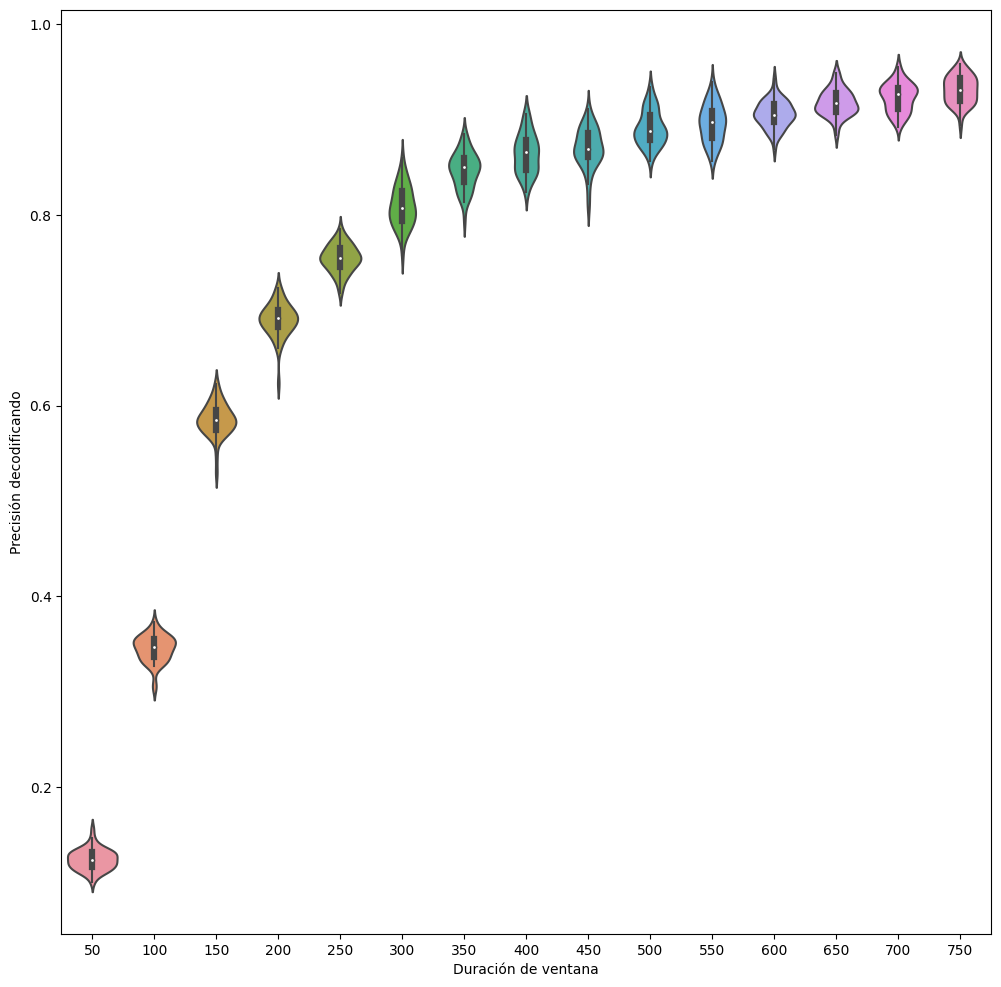

In [8]:
import pandas as pd
fig = plt.figure(figsize=(12,12))
ax = sns.violinplot(data=pd.DataFrame(decode_perf.T, columns=np.arange(50,800,50)))
#Para el que nunca haya visto Violinplots antes, son escencialmente histogramas que han sido suavizados y espejados para facilitar la visualización
ax.set(xlabel='Duración de ventana', ylabel='Precisión decodificando')

Del gráfico podemos observar que aproximadamente a partir de una ventana de planificación de 300ms logramos obtener rendimiento razonable (por encima del 80%) para la decodificación.

### Ejercicio 1.c

In [9]:
decode_perf = []

for offset in range(50,550,50):
    plan_spikes = extract_plan_spikes(window_length=250, start_offset=offset)
    decode_perf.append([])

    # Arma sets de entrenamiento y testeo 50 veces
    for i in range(50):
        # Armar seleccionar los sets de entrenamiento y testeo al azar
        training_trials = [] # será una lista de 8 listas de episodios
        test_trials = [] # todos los demás
        for c in range(8):
            target_trials = np.argwhere((trial_reach_target==c)).squeeze()
            # seleccionar 25 episodios al azar (por cada dirección)
            random_training_trials = np.random.choice(target_trials, 25, replace=False)
            training_trials.append(random_training_trials)
            remaining_test_trials = np.setdiff1d(target_trials, random_training_trials)

            test_trials.extend(remaining_test_trials)
        # Calcular los disparos medios (mean_spike_counts) usando los datos de entrenamiento
        num_neurons = plan_spikes.shape[1]
        mean_spike_counts = np.zeros((num_neurons, 8))
        for c in range(8):
            mean_spike_counts[:,c] = np.mean(plan_spikes[training_trials[c],:], axis=0)
        # Calcular las verosimilitudes para cada target
        poisson_likelihood = np.zeros((len(test_trials), 8))
        for c in range(8):
            m = mean_spike_counts[:,c]
            poisson_likelihood[:,c] = \
                multivariate_poisson_logpdf(m, plan_spikes[test_trials,:])

        # Decodificar eligiendo cual es el objetivo más probable
        correct_targets = trial_reach_target[test_trials] # target correcto para cada episodio
        decoded_targets = np.argmax(poisson_likelihood,axis=1) # el target decodificado es el que nos dá la mayor verosimilitud!

        decode_perf[-1].append(np.mean(correct_targets==decoded_targets))

decode_perf = np.array(decode_perf) # convertir a numpy array

[Text(0.5, 0, 'Duración de ventana'), Text(0, 0.5, 'Precisión decodificando')]

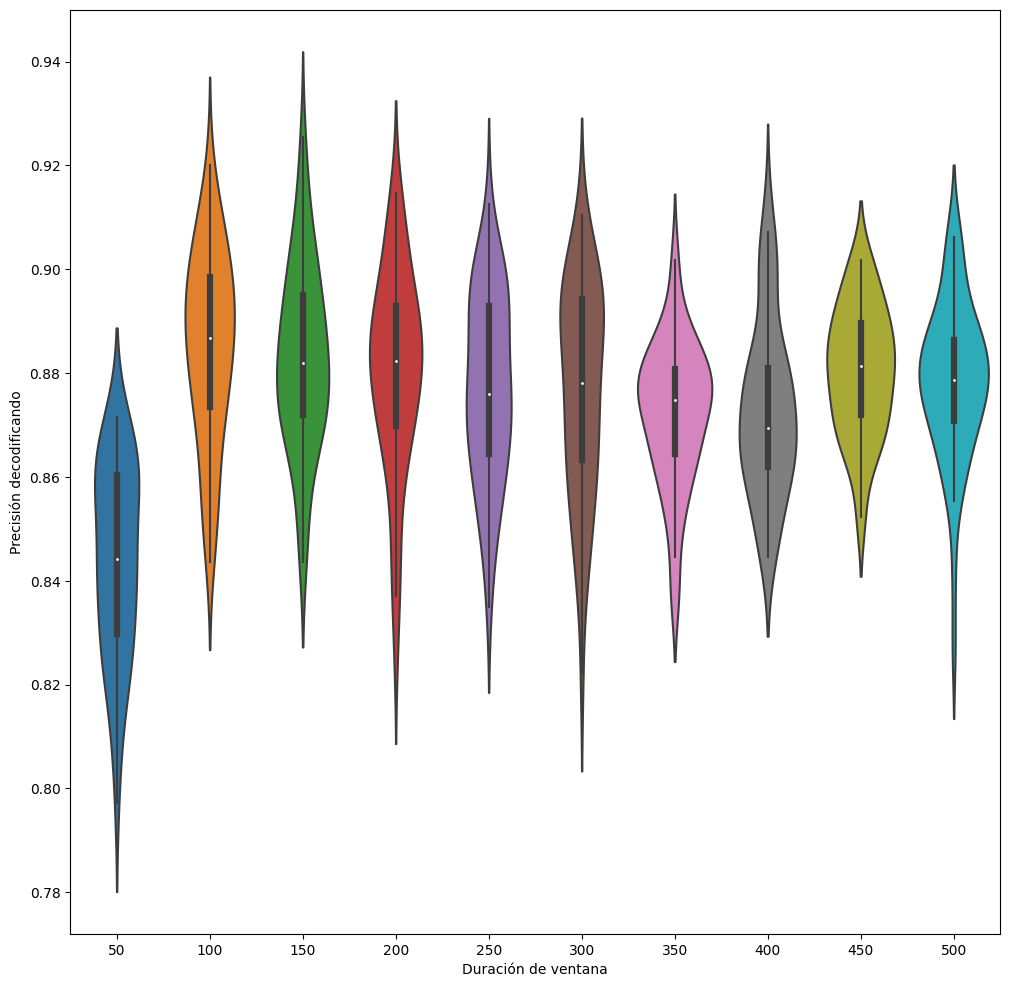

In [10]:
import pandas as pd
fig = plt.figure(figsize=(12,12))
ax = sns.violinplot(data=pd.DataFrame(decode_perf.T, columns=np.arange(50,550,50)))
#Para el que nunca haya visto Violinplots antes, son escencialmente histogramas que han sido suavizados y espejados para facilitar la visualización
ax.set(xlabel='Duración de ventana', ylabel='Precisión decodificando')

Con esta ventana de planificación (250ms), el modelo logra un rendimiento cercano al 90% para la decodificación.

Podemos ver en el gráfico que el rendimiento es mucho más estable y no hay tanta variabilidad en el rendimiento a pesar de estar modificando el offset.

Además, tras observar el gráfico, también podemos concluir que el mejor momento para decodificar es a los 100ms de comenzada la ventana, es decir, en este momento la actividad neuronal es más informativa para predecir el movimiento futuro del mono. 